<a href="https://www.kaggle.com/code/ayamahmoudelgamal/segmentation-car-damage?scriptVersionId=296046903" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ultralytics -q
!pip install opencv-python-headless -q
!pip install pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.7 MB/s eta 0:00:00


In [2]:
import os
import shutil
import yaml
from pathlib import Path
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import json
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:

dataset_path = '/kaggle/input/car-damage/CarDD_SOD'

# Create output directories
output_dir = '/kaggle/working/yolov26_cardd'
os.makedirs(output_dir, exist_ok=True)

# YOLOv26 format dataset structure
yolo_dataset_dir = os.path.join(output_dir, 'dataset')
os.makedirs(yolo_dataset_dir, exist_ok=True)

In [4]:
# Check dataset structure
print("Dataset structure:")
for split in ['CarDD-TR', 'CarDD-VAL', 'CarDD-TE']:
    split_path = os.path.join(dataset_path, split)
    if os.path.exists(split_path):
        print(f"\n{split}:")
        for subfolder in os.listdir(split_path):
            subfolder_path = os.path.join(split_path, subfolder)
            if os.path.isdir(subfolder_path):
                num_files = len(os.listdir(subfolder_path))
                print(f"  - {subfolder}: {num_files} files")
    else:
        print(f"\n{split}: NOT FOUND")

Dataset structure:

CarDD-TR:
  - CarDD-TR-Edge: 2816 files
  - CarDD-TR-Mask: 2816 files
  - CarDD-TR-Image: 2816 files

CarDD-VAL:
  - CarDD-VAL-Image: 810 files
  - CarDD-VAL-Edge: 810 files
  - CarDD-VAL-Mask: 810 files

CarDD-TE:
  - CarDD-TE-Mask: 374 files
  - CarDD-TE-Edge: 374 files
  - CarDD-TE-Image: 374 files


In [5]:
def mask_to_yolo_segmentation(mask_path, output_txt_path, class_id=0):
    """
    Convert binary mask to YOLO segmentation format.
    
    Args:
        mask_path: Path to mask image
        output_txt_path: Path to output .txt file
        class_id: Class ID for the damage (default: 0)
    """
    # Read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Warning: Could not read mask: {mask_path}")
        return False
    
    h, w = mask.shape
    
    # Threshold mask to binary
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        # No damage found, create empty file
        with open(output_txt_path, 'w') as f:
            pass
        return True
    
    # Write YOLO format annotations
    with open(output_txt_path, 'w') as f:
        for contour in contours:
            # Simplify contour to reduce points
            epsilon = 0.001 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Skip very small contours
            if len(approx) < 3:
                continue
            
            # Normalize coordinates
            normalized_points = []
            for point in approx:
                x, y = point[0]
                normalized_points.append(f"{x/w:.6f}")
                normalized_points.append(f"{y/h:.6f}")
            
            # Write line: class_id x1 y1 x2 y2 ...
            f.write(f"{class_id} {' '.join(normalized_points)}\n")
    
    return True

In [6]:
def prepare_yolo_dataset(source_path, dest_path):
    """
    Prepare dataset in YOLOv8 format.
    
    Expected structure:
    dest_path/
        images/
            train/
            val/
            test/
        labels/
            train/
            val/
            test/
    """
    splits = {
        'CarDD-TR': 'train',
        'CarDD-VAL': 'val',
        'CarDD-TE': 'test'
    }
    
    for source_split, yolo_split in splits.items():
        print(f"\nProcessing {source_split} -> {yolo_split}...")
        
        source_split_path = os.path.join(source_path, source_split)
        if not os.path.exists(source_split_path):
            print(f"Warning: {source_split_path} not found, skipping...")
            continue
        
        # Create directories
        images_dir = os.path.join(dest_path, 'images', yolo_split)
        labels_dir = os.path.join(dest_path, 'labels', yolo_split)
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        
        # Get image and mask folders - CORRECTED folder names
        image_folder = os.path.join(source_split_path, f'{source_split}-Image')
        mask_folder = os.path.join(source_split_path, f'{source_split}-Mask')
        
        if not os.path.exists(image_folder) or not os.path.exists(mask_folder):
            print(f"Warning: image or mask folder not found in {source_split_path}")
            print(f"  Looking for: {image_folder}")
            print(f"  Looking for: {mask_folder}")
            continue
        
        # Process each image
        image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        processed = 0
        for img_file in image_files:
            # Copy image
            src_img = os.path.join(image_folder, img_file)
            dst_img = os.path.join(images_dir, img_file)
            shutil.copy2(src_img, dst_img)
            
            # Convert mask to YOLO format
            base_name = os.path.splitext(img_file)[0]
            mask_file = None
            
            # Try different mask extensions
            for ext in ['.jpg', '.jpeg', '.png']:
                potential_mask = os.path.join(mask_folder, base_name + ext)
                if os.path.exists(potential_mask):
                    mask_file = potential_mask
                    break
            
            if mask_file:
                label_file = os.path.join(labels_dir, base_name + '.txt')
                mask_to_yolo_segmentation(mask_file, label_file, class_id=0)
                processed += 1
            else:
                print(f"Warning: Mask not found for {img_file}")
        
        print(f"Processed {processed} images for {yolo_split}")

# Prepare the dataset
prepare_yolo_dataset(dataset_path, yolo_dataset_dir)


Processing CarDD-TR -> train...
Processed 2816 images for train

Processing CarDD-VAL -> val...
Processed 810 images for val

Processing CarDD-TE -> test...
Processed 374 images for test


 # Negative Processing

In [7]:

class NegativeOnlyDatasetProcessor:
    """
    Prepare NEGATIVE samples only:
    - copy images
    - generate blank masks
    - generate empty YOLO label (.txt)
    """

    def __init__(
        self,
        negative_data_path,
        output_path,
        train_ratio=0.7,
        valid_ratio=0.2,
        test_ratio=0.1,
        max_images=None
    ):
        self.negative_data_path = Path(negative_data_path)
        self.output_path = Path(output_path)
        self.train_ratio = train_ratio
        self.valid_ratio = valid_ratio
        self.test_ratio = test_ratio
        self.max_images = max_images

        self.output_path.mkdir(parents=True, exist_ok=True)
        self._validate_paths()

    def _validate_paths(self):
        print("\n🔍 Validating negative dataset path...")
        if not self.negative_data_path.exists():
            raise ValueError(f"❌ Path not found: {self.negative_data_path}")
        print(f"  ✓ Found: {self.negative_data_path}")

    def get_images(self):
        print("\n📥 Collecting negative images...")
        exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        images = []
        for ext in exts:
            images.extend(self.negative_data_path.rglob(ext))

        images = sorted(list(set(images)))

        if len(images) == 0:
            raise ValueError("❌ No images found!")

        if self.max_images and len(images) > self.max_images:
            random.seed(42)
            images = random.sample(images, self.max_images)

        print(f"  ✓ Found {len(images)} images")
        return images

    def split(self, images):
        train_val, test = train_test_split(
            images, test_size=self.test_ratio, random_state=42
        )

        val_ratio_adj = self.valid_ratio / (self.train_ratio + self.valid_ratio)
        train, valid = train_test_split(
            train_val, test_size=val_ratio_adj, random_state=42
        )

        return {"train": train, "valid": valid, "test": test}

    def create_blank_mask(self, image_path):
        img = cv2.imread(str(image_path))
        h, w = img.shape[:2]
        return np.zeros((h, w), dtype=np.uint8)

    def process_split(self, split_name, images):
        print(f"\n📁 Processing {split_name} ({len(images)} images)")

        split_dir = self.output_path / split_name
        img_dir = split_dir / "images"
        mask_dir = split_dir / "masks"
        label_dir = split_dir / "labels"

        img_dir.mkdir(parents=True, exist_ok=True)
        mask_dir.mkdir(parents=True, exist_ok=True)
        label_dir.mkdir(parents=True, exist_ok=True)

        for idx, img_path in enumerate(tqdm(images)):
            name = f"neg_{idx:06d}{img_path.suffix}"

            # Copy image
            shutil.copy2(img_path, img_dir / name)

            # Blank mask
            mask = self.create_blank_mask(img_path)
            cv2.imwrite(str(mask_dir / name), mask)

            # Empty label file (YOLO negative)
            open(label_dir / f"{Path(name).stem}.txt", "w").close()

    def run(self):
        print("=" * 60)
        print("🚀 NEGATIVE DATASET PREPARATION")
        print("=" * 60)

        images = self.get_images()
        splits = self.split(images)

        for split_name, imgs in splits.items():
            self.process_split(split_name, imgs)

        print("\n✅ Done!")
        print(f"📂 Output saved to: {self.output_path}")


In [8]:
processor = NegativeOnlyDatasetProcessor(
    negative_data_path="/kaggle/input/negative-data-for-damage-car/Negative Samples",
    output_path="/kaggle/working/negative_dataset",
    max_images=2500
)

processor.run()


🔍 Validating negative dataset path...
  ✓ Found: /kaggle/input/negative-data-for-damage-car/Negative Samples
🚀 NEGATIVE DATASET PREPARATION

📥 Collecting negative images...
  ✓ Found 2500 images

📁 Processing train (1749 images)


100%|██████████| 1749/1749 [00:28<00:00, 61.87it/s]



📁 Processing valid (501 images)


100%|██████████| 501/501 [00:08<00:00, 59.30it/s]



📁 Processing test (250 images)


100%|██████████| 250/250 [00:03<00:00, 65.86it/s]


✅ Done!
📂 Output saved to: /kaggle/working/negative_dataset


# Merge

In [9]:
import shutil
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

class UnifiedYOLODatasetMerger:
    def __init__(self, positive_path, negative_path, output_path):
        self.pos = Path(positive_path)
        self.neg = Path(negative_path)
        self.out = Path(output_path)
        self.out.mkdir(parents=True, exist_ok=True)

    # -------------------------
    # Helpers
    # -------------------------
    def _ensure_dirs(self, split):
        for d in ["images", "labels", "masks"]:
            (self.out / split / d).mkdir(parents=True, exist_ok=True)

    def _blank_mask(self, img_path):
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]
        return np.zeros((h, w), dtype=np.uint8)

    # -------------------------
    # POSITIVE DATASET
    # -------------------------
    def copy_positive(self, split):
        print(f"\n➕ Copying POSITIVE {split}")

        img_src = self.pos / "images" / split
        lbl_src = self.pos / "labels" / split

        for img_path in tqdm(list(img_src.iterdir())):
            if img_path.suffix.lower() not in [".jpg", ".png", ".jpeg"]:
                continue

            name = img_path.name

            # image
            shutil.copy2(img_path, self.out / split / "images" / name)

            # label
            lbl = lbl_src / f"{img_path.stem}.txt"
            shutil.copy2(lbl, self.out / split / "labels" / lbl.name)

            # mask (generate if not exists)
            mask_path = self.out / split / "masks" / name
            if not mask_path.exists():
                mask = self._blank_mask(img_path)
                cv2.imwrite(str(mask_path), mask)

    # -------------------------
    # NEGATIVE DATASET
    # -------------------------
    def copy_negative(self, split):
        print(f"\n➖ Copying NEGATIVE {split}")

        for sub in ["images", "labels", "masks"]:
            src = self.neg / split / sub
            dst = self.out / split / sub

            for f in tqdm(list(src.iterdir())):
                new_name = f"neg_{f.name}"
                shutil.copy2(f, dst / new_name)

    # -------------------------
    # RUN
    # -------------------------
    def run(self):
        print("=" * 70)
        print("🚀 MERGING POSITIVE + NEGATIVE DATASETS")
        print("=" * 70)

        split_neg =["train", "valid", "test"]
        split_pos = ["train", "val", "test"]

        for split in split_pos :
            self._ensure_dirs(split)
            self.copy_positive(split)

        for split in split_neg :
            self._ensure_dirs(split)
            self.copy_negative(split)

        print("\n✅ MERGE COMPLETE")
        print(f"📂 Final dataset: {self.out}")


In [10]:
merger = UnifiedYOLODatasetMerger(
    positive_path="/kaggle/working/yolov26_cardd/dataset",
    negative_path="/kaggle/working/negative_dataset",
    output_path="/kaggle/working/final_car_damage"
)

merger.run()


🚀 MERGING POSITIVE + NEGATIVE DATASETS

➕ Copying POSITIVE train


100%|██████████| 2816/2816 [00:44<00:00, 63.82it/s]



➕ Copying POSITIVE val


100%|██████████| 810/810 [00:12<00:00, 63.14it/s]



➕ Copying POSITIVE test


100%|██████████| 374/374 [00:05<00:00, 64.03it/s]



➖ Copying NEGATIVE train


100%|██████████| 1749/1749 [00:00<00:00, 7596.68it/s]



➖ Copying NEGATIVE valid


100%|██████████| 501/501 [00:00<00:00, 7361.78it/s]



➖ Copying NEGATIVE test


100%|██████████| 250/250 [00:00<00:00, 7328.09it/s]


✅ MERGE COMPLETE
📂 Final dataset: /kaggle/working/final_car_damage


In [11]:
import shutil
from pathlib import Path
from tqdm import tqdm

def merge_valid_into_val(dataset_path):
    dataset_path = Path(dataset_path)

    val_dir = dataset_path / "val"
    valid_dir = dataset_path / "valid"

    if not valid_dir.exists():
        print("✅ No 'valid' directory found. Nothing to do.")
        return

    print("🔄 Merging 'valid' → 'val'")

    for split_sub in ["images", "labels", "masks"]:
        src = valid_dir / split_sub
        dst = val_dir / split_sub

        if not src.exists():
            continue

        dst.mkdir(parents=True, exist_ok=True)

        for f in tqdm(list(src.iterdir()), desc=f"   moving {split_sub}"):
            target = dst / f.name

            # avoid overwrite
            if target.exists():
                target = dst / f"valid_{f.name}"

            shutil.move(str(f), str(target))

    # Remove valid dir if empty
    try:
        shutil.rmtree(valid_dir)
        print("🧹 Removed empty 'valid/' directory")
    except Exception:
        print("⚠️ Could not remove 'valid/' (not empty?)")

    print("✅ Merge complete")


In [12]:
merge_valid_into_val("/kaggle/working/final_car_damage")

🔄 Merging 'valid' → 'val'


   moving masks: 100%|██████████| 501/501 [00:00<00:00, 24373.89it/s]

🧹 Removed empty 'valid/' directory
✅ Merge complete


In [13]:
# Create YAML configuration
merged_data_dir = "/kaggle/working/final_car_damage"
yaml_config = {
    'path': yolo_dataset_dir,  # Root directory
    'train': os.path.join(yolo_dataset_dir, 'images/train'),  # Absolute path
    'val': os.path.join(yolo_dataset_dir, 'images/val'),      # Absolute path
    'test': os.path.join(yolo_dataset_dir, 'images/test'),    # Absolute path
    'names': {
        0: 'damage',
        1: "no_damage"
    },
    'nc': 2  # Number of classes
}

yaml_path = os.path.join(output_dir, 'merged.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print(f"YAML configuration saved to: {yaml_path}")
print("\nConfiguration:")
print(yaml.dump(yaml_config, default_flow_style=False))

# Verify the paths exist
print("\nVerifying dataset structure:")
for split in ['train', 'val', 'test']:
    img_path = os.path.join(yolo_dataset_dir, 'images', split)
    lbl_path = os.path.join(yolo_dataset_dir, 'labels', split)
    
    if os.path.exists(img_path):
        num_images = len([f for f in os.listdir(img_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"✓ {split}/images: {num_images} images")
    else:
        print(f"✗ {split}/images: NOT FOUND")
    
    if os.path.exists(lbl_path):
        num_labels = len([f for f in os.listdir(lbl_path) if f.endswith('.txt')])
        print(f"✓ {split}/labels: {num_labels} labels")
    else:
        print(f"✗ {split}/labels: NOT FOUND")

YAML configuration saved to: /kaggle/working/yolov26_cardd/merged.yaml

Configuration:
names:
  0: damage
  1: no_damage
nc: 2
path: /kaggle/working/yolov26_cardd/dataset
test: /kaggle/working/yolov26_cardd/dataset/images/test
train: /kaggle/working/yolov26_cardd/dataset/images/train
val: /kaggle/working/yolov26_cardd/dataset/images/val


Verifying dataset structure:
✓ train/images: 2816 images
✓ train/labels: 2816 labels
✓ val/images: 810 images
✓ val/labels: 810 labels
✓ test/images: 374 images
✓ test/labels: 374 labels


Visualizing training samples:
Visualizing 3 samples from train set...


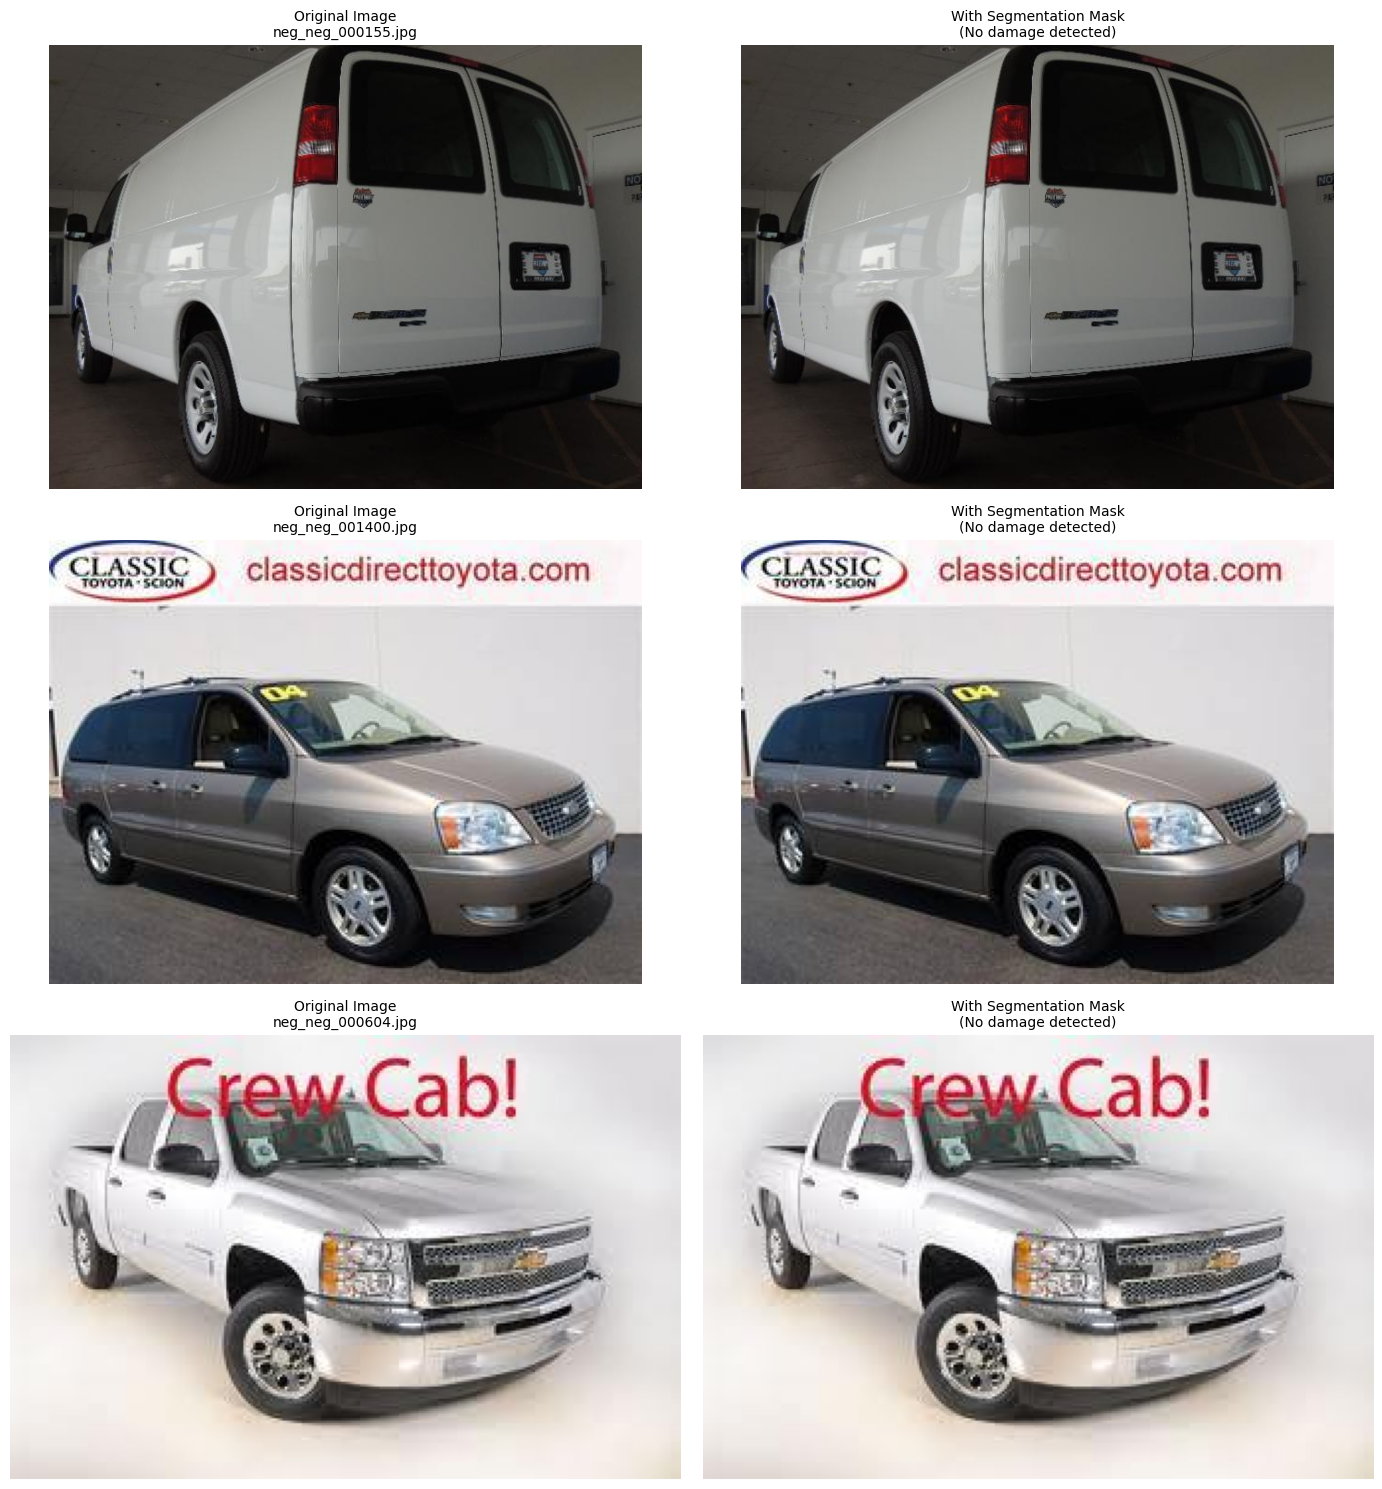

✓ Visualization complete!

Visualizing validation samples:
Visualizing 2 samples from val set...


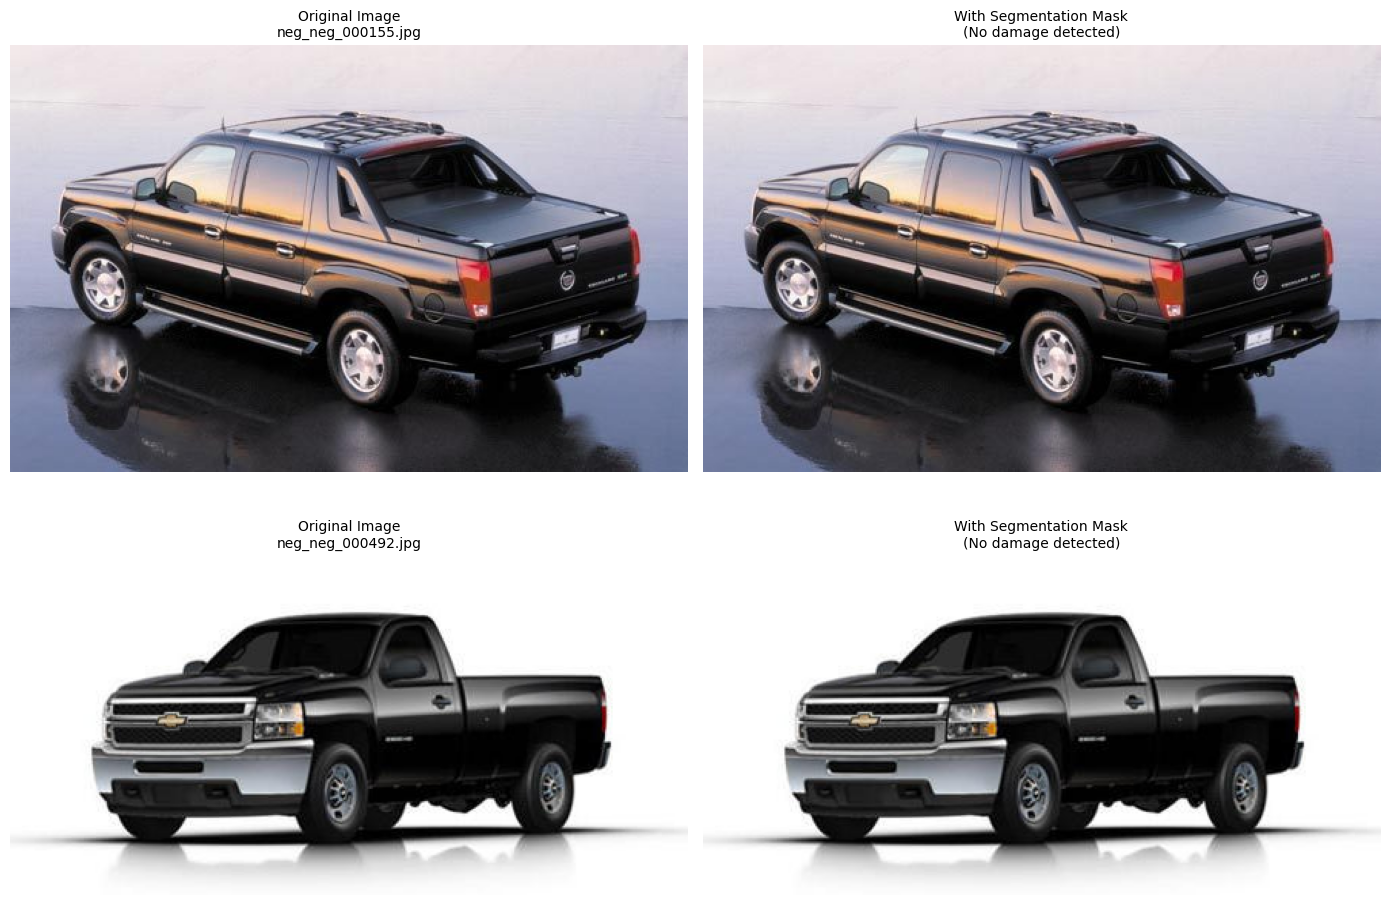

✓ Visualization complete!


In [14]:
def visualize_sample(dataset_dir, split='train', num_samples=3):
    """
    Visualize sample images with their segmentation annotations.
    """
    images_dir = os.path.join(dataset_dir, split, "images")
    labels_dir = os.path.join(dataset_dir, split, 'labels')
    
    # Check if directories exist
    if not os.path.exists(images_dir):
        print(f"Error: Images directory not found: {images_dir}")
        return
    
    if not os.path.exists(labels_dir):
        print(f"Error: Labels directory not found: {labels_dir}")
        return
    
    # Get image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(image_files) == 0:
        print(f"Error: No images found in {images_dir}")
        return
    
    # Limit to available samples
    num_samples = min(num_samples, len(image_files))
    image_files = image_files[:num_samples]
    
    print(f"Visualizing {num_samples} samples from {split} set...")
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_file in enumerate(image_files):
        # Read image
        img_path = os.path.join(images_dir, img_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Warning: Could not read image: {img_file}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Read label
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)
        
        # Create mask overlay
        mask = np.zeros((h, w, 3), dtype=np.uint8)
        num_annotations = 0
        
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 7:  # At least class + 3 points (x,y pairs)
                        continue
                    
                    # Parse polygon points
                    points = []
                    for i in range(1, len(parts), 2):
                        if i+1 < len(parts):
                            x = int(float(parts[i]) * w)
                            y = int(float(parts[i+1]) * h)
                            points.append([x, y])
                    
                    if len(points) >= 3:
                        points = np.array(points, dtype=np.int32)
                        # Draw filled polygon on mask
                        cv2.fillPoly(mask, [points], (0, 255, 0))
                        # Draw contour
                        cv2.polylines(mask, [points], True, (255, 255, 0), 2)
                        num_annotations += 1
        
        # Create overlay with transparency
        if num_annotations > 0:
            overlay = cv2.addWeighted(img, 0.7, mask, 0.3, 0)
            title_suffix = f'({num_annotations} damage region(s))'
        else:
            overlay = img.copy()
            title_suffix = '(No damage detected)'
        
        # Display original image
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Original Image\n{img_file}', fontsize=10)
        axes[idx, 0].axis('off')
        
        # Display annotated image
        axes[idx, 1].imshow(overlay)
        axes[idx, 1].set_title(f'With Segmentation Mask\n{title_suffix}', fontsize=10)
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"✓ Visualization complete!")

# Visualize samples from training set
print("Visualizing training samples:")
visualize_sample(merged_data_dir, 'train', num_samples=3)

# Optionally visualize validation samples too
print("\nVisualizing validation samples:")
visualize_sample(merged_data_dir, 'val', num_samples=2)

In [15]:
# Load pretrained YOLOv26m-seg model
model = YOLO('yolo26m-seg.pt')

print("Model loaded successfully!")
print(f"Model: YOLOv26m-seg")

Model loaded successfully!
Model: YOLOv26m-seg


In [16]:
# Training parameters
EPOCHS = 100
BATCH_SIZE = 16
IMG_SIZE = 640
PATIENCE = 10  # Early stopping patience

# Train the model
results = model.train(
    data=yaml_path,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    patience=PATIENCE,
    save=True,
    device=0,  # Use GPU 0, or 'cpu' for CPU training
    project=output_dir,
    name='train',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.8,
    box=7.5,
    cls=0.5,
    dfl=1.5,
    plots=True,
    verbose=True
)

print("\nTraining completed!")

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolov26_cardd/merged.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10

In [17]:
# # Validate on validation set
# metrics = model.val(
#     data=yaml_path,
#     split='val',
#     imgsz=IMG_SIZE,
#     batch=BATCH_SIZE,
#     plots=True
# )

# print("\nValidation Metrics:")
# print(f"Box mAP50: {metrics.box.map50:.4f}")
# print(f"Box mAP50-95: {metrics.box.map:.4f}")
# print(f"Mask mAP50: {metrics.seg.map50:.4f}")
# print(f"Mask mAP50-95: {metrics.seg.map:.4f}")

In [18]:
# # Test on test set
# test_metrics = model.val(
#     data=yaml_path,
#     split='test',
#     imgsz=IMG_SIZE,
#     batch=BATCH_SIZE,
#     plots=True
# )

# print("\nTest Metrics:")
# print(f"Box mAP50: {test_metrics.box.map50:.4f}")
# print(f"Box mAP50-95: {test_metrics.box.map:.4f}")
# print(f"Mask mAP50: {test_metrics.seg.map50:.4f}")
# print(f"Mask mAP50-95: {test_metrics.seg.map:.4f}")

In [19]:
# # Get some test image 
# test_images_dir = os.path.join(yolo_dataset_dir, 'images', 'test')

# # choose 5 picture Random 
# all_images = [os.path.join(test_images_dir, f) 
#               for f in os.listdir(test_images_dir) 
#               if f.endswith(('.jpg', '.jpeg', '.png'))]
# test_images = random.sample(all_images, 5)  # اختيار عشوائي

# # Run predictions
# results = model.predict(
#     source=test_images,
#     imgsz=IMG_SIZE,
#     conf=0.25,
#     save=True,
#     project=output_dir,
#     name='predictions',
#     exist_ok=True
# )

# print(f"\nPredictions saved to: {output_dir}/predictions")

# # Display original and predicted images
# fig, axes = plt.subplots(len(test_images), 2, figsize=(12, 6*len(test_images)))

# if len(test_images) == 1:
#     axes = [axes]

# for idx, result in enumerate(results):
#     # picture before prediction 
#     original_img = cv2.imread(test_images[idx])
#     original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

#     # picture after prediction 
#     pred_img = result.plot()
#     pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

#     axes[idx][0].imshow(original_img)
#     axes[idx][0].set_title(f'Original {idx+1}')
#     axes[idx][0].axis('off')

#     axes[idx][1].imshow(pred_img)
#     axes[idx][1].set_title(f'Prediction {idx+1}')
#     axes[idx][1].axis('off')

# plt.tight_layout()
# plt.show()


In [20]:
# The best model is automatically saved during training
best_model_path = os.path.join(output_dir, 'train', 'weights', 'best.pt')
last_model_path = os.path.join(output_dir, 'train', 'weights', 'last.pt')

print(f"Best model saved at: {best_model_path}")
print(f"Last model saved at: {last_model_path}")

# Export to different formats if needed
print("\nExporting model to ONNX format...")
model.export(format='onnx', imgsz=IMG_SIZE)
print("Export completed!")

Best model saved at: /kaggle/working/yolov26_cardd/train/weights/best.pt
Last model saved at: /kaggle/working/yolov26_cardd/train/weights/last.pt

Exporting model to ONNX format...
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO26m-seg summary (fused): 149 layers, 23,509,010 parameters, 0 gradients, 121.2 GFLOPs

PyTorch: starting from '/kaggle/working/yolov26_cardd/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 300, 38), (1, 32, 160, 160)) (51.9 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 361ms
Prepared 4 packages in 3.12s
Installed 4 packages in 20ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.23.2
 + 

/usr/local/lib/python3.12/dist-packages/torch/onnx/utils.py:1397: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/onnx/symbolic_opset9.py:5350: UserWarning: Exporting aten::index operator of advanced indexing in opset 22 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


ONNX: slimming with onnxslim 0.1.83...
ONNX: export success ✅ 8.9s, saved as '/kaggle/working/yolov26_cardd/train/weights/best.onnx' (90.0 MB)

Export complete (11.7s)
Results saved to /kaggle/working/yolov26_cardd/train/weights
Predict:         yolo predict task=segment model=/kaggle/working/yolov26_cardd/train/weights/best.onnx imgsz=640 
Validate:        yolo val task=segment model=/kaggle/working/yolov26_cardd/train/weights/best.onnx imgsz=640 data=/kaggle/working/yolov26_cardd/merged.yaml  
Visualize:       https://netron.app
Export completed!


In [21]:

# #paths files
# yolo_dataset_dir = "/kaggle/working/yolov8_cardd/dataset"
# onnx_model_path = "/kaggle/working/yolov8_cardd/train/weights/best.pt"
# output_dir = "/kaggle/working/yolov8_cardd/onnx_predictions"
# IMG_SIZE = 640

# model = YOLO(onnx_model_path)
# model.task = "segment" 

# # choose five picture random 
# test_images_dir = os.path.join(yolo_dataset_dir, 'images', 'test')
# all_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir)
#               if f.endswith(('.jpg', '.jpeg', '.png'))]
# test_images = random.sample(all_images, 5)  

# # predict image 
# results = []
# for img_path in test_images:
#     result = model.predict(
#         source=img_path,
#         imgsz=IMG_SIZE,
#         conf=0.25,
#         save=True,
#         project=output_dir,
#         name='predictions',
#         exist_ok=True
#     )[0]  
#     results.append(result)

# print(f"\nPredictions saved to: {output_dir}/predictions")

# # show imaage before and after predict 
# fig, axes = plt.subplots(len(test_images), 2, figsize=(12, 5*len(test_images)))

# for idx, (image_path, result) in enumerate(zip(test_images, results)):
#     orig_img = cv2.imread(image_path)
#     orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
#     pred_img = result.plot()
#     pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    
#     axes[idx, 0].imshow(orig_img)
#     axes[idx, 0].set_title(f'Original Image {idx+1}')
#     axes[idx, 0].axis('off')
    
#     axes[idx, 1].imshow(pred_img)
#     axes[idx, 1].set_title(f'Prediction {idx+1}')
#     axes[idx, 1].axis('off')

# plt.tight_layout()
# plt.show()


In [22]:
# Remove any failed yolo dataset attempts
if os.path.exists('/kaggle/working/yolov26_cardd'):
    shutil.rmtree('/kaggle/working/yolov26_cardd')
    print("Deleted: yolov26_cardd")

Deleted: yolov26_cardd
